<p style="text-align: center; font-size:200%;" size=10>
<span style="color:blue"> City of Tijuana, Metropolitan Transit System analysis</span> </p>
<p style="text-align: center; font-size:150%;" size=10> Transporte Vehicular Metropolitano (TVM) </p>

**Table of contents**:
1. [Libraries](#TVM_LIB).
2. [Experimental hyperparameters](#TVM_HP).
3. [Helper functions](#TVM_HELPER)
4. [Metrics](#TVM_METRICS). 
5. [Data analysis workflow](#TVM_WF).
6. [Data visualization](#TVM_VZ).
7. [Statistical data analysis](#TVM_SDT).
8. [References](#TVM_REF).

**Please reference the following publication if you intend to use the dataset or code in this repository**:
- In process.

### <a name="TVM_LIB">1. <span style="color:blue">Libraries</span></a>

In [1]:
# Filter warnings
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['PROJ_LIB'] = r'C:\Users\ahiralesc\Anaconda3\pkgs\proj-6.3.0-ha7a8c7b_0\Library\share'
# r'C:\Users\username\AppData\Local\Continuum\anaconda2\pkgs\proj4-4.9.2-vc10_0\Library\share'

In [2]:
import geojson                           # Utilities
import pyproj 
from math import sin,cos,sqrt,asin,pi    
from math import radians                 
from decimal import *
from collections import Counter
from networkx.utils import UnionFind
import heapq
import csv


import networkx as nx                    # Graph modelling see https://networkx.github.io/
import numpy as np
import json

import pandas as pd                      # Metrics
from abc import ABCMeta, abstractmethod  # Metrics


from sklearn.manifold import TSNE        # Statistical data analysis
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go

#from sklearn.cluster import DBSCAN       # Clustering
#import hdbscan 
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt           # Visualization
from matplotlib.pyplot import *
import seaborn as sns
from mpl_toolkits.basemap import Basemap  # Map visualization
import ipyvolume                          # 3D visualization
import ipyvolume as ipv
import vaex
from bokeh.io import output_notebook, show # Bokeh visualization
from bokeh.plotting import figure

output_notebook()
%matplotlib inline

Loading BokehJS ...

### <a name="TVM_HP">2. <span style="color:blue">Experimental hyperparameters</span></a>

The transport routes were edited with [JOSM](https://josm.openstreetmap.de/) Ver. 15238, an extensible editor for Open Street Map. The complete transportation network agregates 104 independent routes, with a total of 20,411 nodes. Routes share 80% of nodes, since they overlap and share intersections, reducing the node dataset to 4,461 unique nodes.  See Fig. 1. 
<br>
<img src="img/image.png" width="600" height="100">
<p style="text-align: center;">**Figure 1.** 104 routes at Tijuana transportation network.</p>
<br>
Six datasets are made available. Datasets with two, six, seven and twenty two routes were used for testing and simple data analysis and visualization. The complete transport network contains  104 independent routes. The  merged route dataset is used in the final analysis (104_routes.geojson). Datasets are in [geojson](https://geojson.org/) formated, an encoding format for geographic data structures. 
<br>
<p style="text-align: center;">**Table I.** Tijuana transportation network datasets.</p>

| No. routes | No. polygons | dataset | 
|:--------:|:----------:|:------------|
| 104 | 0 | 104MR0P.geojson |

In [3]:
# hyperparameters   'ND','NDC','NiDC','NoDC','NBC','NCC','NLRC','NKC','NCCO','NCCW','KNN','KNNW'
# Node metrics centrality : 'ND','NDC','NiDC','NoDC','NBC','NCC','NLRC','NKC','NCPR'
# Node metrics clustering : 'NCCO','NCCW','KNN','KNNW'
# Global metrics: 'NLDA','NLD','NGRC','NLT'

hp = {                       
    "source_geojson"      : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P.geojson", # TODO: update with your path
    "node_metrics"        : ['ND','NDC','NiDC','NoDC','NBC','NCC','NLRC','NKC','NCCO','NCCW','KNN','KNNW','NCPR','HITS'],
    "edge_metrics"        : [ ], #TODO:
    "global_metrics"      : ['NLDA','NLD','NGRC','NLT'], 
    "plot_node_metrics"   : ['ND','NDC','NiDC','NoDC','NBC','NCC','NLRC','NKC','NCCO','NCCW','KNN','KNNW','NCPR'],
    "plot_edge_metrics"   : [ ], #TODO:
    "plot_global_metrics" : ['NLDA','NLD','NGRC','NLT'],
    "persistance"    : { "node_metrics"   : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_node_metrics.cvs",
                         "edge_metrics"   : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_edge_metrics.cvs",
                         "global_metrics" : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_global_metrics.cvs",
                         "dag"            : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_dag.pickle",
                         "node_tsne"      : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_node_tsne.cvs",
                         "edge_tsne"      : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_edge_tsne.cvs",
                         "node_clusters"  : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_node_clus.cvs",
                         "edge_clusters"  : r"C:\Users\ahiralesc\Datasets\tvm\104MR0P_edge_clus.cvs"
                       }
}    
    
 

### <a name="TVM_HELPER">3. <span style="color:blue">Helper functions</span></a>

In [4]:
class TVM_Helper:
    
    def __init__(self):
        pass
    
    
    def locations(self, minVal, maxVal, data, field):
        data = (data[(data[field] >= minVal) & (data[field] <=  maxVal)]["Tupla"])
        locations = [v.split(":") for v in data]
        return locations
    
    
    def cargaRutas(self, trayectoriaArchivo):
        df = dict()
    
        # Carga de persistencia
        with open(trayectoriaArchivo) as f:
            rutas = geojson.load(f)
    
        # Determinar el numero de rutas en el archivo
        for r in range(len(rutas['features'])):
            ruta = rutas['features'][r]
            # Nombre de la ruta
            nombre_ruta = ruta['properties']['name']
            etiqueta = ruta['properties']['ref']
            # Extraer los puntos de cada ruta
            puntos   = ruta['geometry']['coordinates']
            dtype  = ruta['geometry']['type']
            df[nombre_ruta] = [puntos, dtype, etiqueta]
    
        return df


    def concatenaCoordenadas(self, tupla):
        return "%s:%s" % (tupla[1],tupla[0])


    
    def transformaRuta(self, ruta):
        l = list()
        for p in ruta:
            k = self.concatenaCoordenadas(p)
            l.append(k)
        return l


    def obtenVertices(self, df):
        vertices = pd.DataFrame(columns=['Tupla', 'Etiqueta', 'Longitud', 'Latitud'])
        vn = 0
        for k in df.keys():
            if df[k][1] == 'LineString':
                l = self.transformaRuta(df[k][0])
                for vertice in l:
                    if vertice not in vertices['Tupla'].unique():
                        etiqueta = "v%s" % (vn)
                        longitud = float(vertice.split(":")[1])
                        latitud  = float(vertice.split(":")[0])
                        vn = vn + 1
                        vertices = vertices.append({'Tupla' : vertice , 'Etiqueta' : etiqueta,
                                               'Longitud' : longitud, 'Latitud' : latitud} , ignore_index=True)
        # Hacer que la tupla sea el indice de la tabla
        vertices.set_index('Tupla',inplace=True)
        return vertices


    def distanciaEntrePuntos(self, o, d):
        name_ellps = "WGS84"
        geod = pyproj.Geod(ellps=name_ellps)

        lat1 = float(o.split(":")[0])
        long1 = float(o.split(":")[1])
        lat2 = float(d.split(":")[0])
        long2 = float(d.split(":")[1])
   
        grad1,grad2,distancia = geod.inv(long1, lat1, long2, lat2)
        return grad1, grad2, distancia


    def obtenAristas(self, df, vertices):
        # La distancia esta en metros (Dist)
        #etiquetas = dict()
        #etq = 0
        #lval = None
        aristas = pd.DataFrame(columns=['Arista', 'Angulo1', 'Angulo2', 'Dist','Etiqueta'])
        for k in df.keys():
            for i in range(len(df[k][0])-1):
                o = self.concatenaCoordenadas(df[k][0][i])
                d = self.concatenaCoordenadas(df[k][0][i+1])
                vo = vertices.loc[[o]]['Etiqueta'][0]
                vd = vertices.loc[[d]]['Etiqueta'][0]
                grad1, grad2, distancia = self.distanciaEntrePuntos(o,d)
                e = (vo,vd)
                #key = str(e)
                #if key in etiquetas.keys():
                #    lval = etiquetas[key]
                #else:
                #    lval = 'r' + str(i)
                #    i = i + 1
                #    etiquetas[key] = lval
                aristas = aristas.append({'Arista' : e , 'Angulo1' : grad1, 'Angulo2' : grad2,
                                          'Dist' : distancia, 'Etiqueta': k} , ignore_index=True)
        return aristas 
    
    
    
    def obtenPoligonos(self, df):
        poligonos = pd.DataFrame(columns=['Nombre', 'Poligono'])
        vn = 0
        for k in df.keys():
            if df[k][1] == 'Polygon':
                poligonos = poligonos.append({'Nombre' : k , 'Poligono' : df[k][0][0]} , ignore_index=True)
        # Hacer que la tupla sea el indice de la tabla
        poligonos.set_index('Nombre',inplace=True)
        return poligonos


    
    def geodetic_a_geocentrica(self, ellipsoid, latitude, longitude, height):
        """ Return geocentric (Cartesian) Coordinates x, y, z corresponding to
            the geodetic coordinates given by latitude and longitude (in
            degrees) and height above ellipsoid. The ellipsoid must be
            specified by a pair (semi-major axis, reciprocal flattening).
            
            Autor: Gareth Rees
        """
        φ = radians(latitude)
        λ = radians(longitude)
        sin_φ = sin(φ)
        a, rf = ellipsoid           # semi-major axis, reciprocal flattening
        e2 = 1 - (1 - 1 / rf) ** 2  # eccentricity squared
        n = a / sqrt(1 - e2 * sin_φ ** 2) # prime vertical radius
        r = (n + height) * cos(φ)   # perpendicular distance from z axis
        x = r * cos(λ)
        y = r * sin(λ)
        z = (n * (1 - e2) + height) * sin_φ
        return x, y, z
        
        
    
    def extraccion_por_region(self, ruta_completa=True):
        from matplotlib import path

        # Parametros elipticos. Medidas en metros.
        WGS84 = 6378137, 298.257223563
        GRS80 = 6378137, 298.257222100882711
            
        # La altura promedio de Tijuama es 20m
        lat = float('43.21009')
        lon = float('-78.120123')
        h = float('20')
        
        # Iteracion sobre los poligonos
        for i, j in regions.iterrows():
            print(print(type(i)), print(type(j[0])))
    
        print(self.geodetic_a_geocentrica(WGS84, lat, lon, h))
        
        
        
        
class Dataset: # Page 50 Bird interface 
     # encoding="ISO-8859-1" o  encoding='utf-8'
    
    def __init__(self):
        self.pdf = None     # the dataset payload
        
    
    def read_cvs(self, filename, separator, encode = "ISO-8859-1",  header=False):
        """
            Loads a CVS formated, with UTF-8 character encoding, corpus to a pandas dataframe.
            By specifying header True the first row  is  is assummed to contain the header 
        """
        try:
            if not header:
                self.pdf = pd.read_csv(filename,  keep_default_na=False, sep=separator,  encoding = encode, header=None, engine='python') 
            else: 
                self.pdf = pd.read_csv(filename, keep_default_na=False, sep=separator,  encoding = encode, names = header, engine='python')
        except IOError as e:
            print(e)
    
    
    def write_cvs(self, filename):
        """
            Writes the dataframe to persistance in CSV formated, with UTF-8 character encoding.
        """
        if self.pdf != None:
            self.pdf.to_csv(filename, index=False,  encoding="ISO-8859-1")     # Do not write row names
    
    
    def raw(self, categories = []):
        """
            The raw content of the corpus in a pandas dataframe or the raw content of the 
            specified fields in the pandas dataframe
        """
        if len(categories) == 0:
            return self.pdf
        else:
            return self.pdf[categories]

### <a name="TVM_METRICS">4. <span style="color:blue">Metrics</span></a>

The study of networks is founded on empirical observations, and on a good understanding of how they are obtained [Newman]

Newman et al states, that the study of netwroks is founded on empirical observations and a goog understanding of what data are available, and how they are obtained. 

Analysis of the network structure enables estimation of quatities that capture particular feautres of the network topology.
Which are the most important or central nodes in the network? Importance is evaluated in terms of the number of incomming links (centrality)


In [5]:
class Metrica(object):              # Clase abstracta que generaliza el concepto de criterio o metrica a aplicar
    
    def __init__(self):             
        self._nombre = None         # El nombre de la metrica
        self._tipo = None           # La clase de metrica a la que pertenece la metrica 
        
    def nombre(self):               # Obtiene el nombre de la metrica
        return self._nombre
    
    def tipo(self):                 # Obtene la clase a la que pertenece la metrica
        return self._tipo
    
    def __to_data_frame__(self, data):
        if isinstance(data, dict):
            pdf = pd.DataFrame(data, index=[0]).transpose()
            pdf.rename(columns={0: self._nombre}, inplace=True)
            pdf.index.name = "Etiqueta"
            return pdf
        if isinstance(data, nx.classes.reportviews.DiDegreeView):
            pdf = pd.DataFrame(dict(data), index=[0]).transpose()
            pdf.rename(columns={0: self._nombre}, inplace=True)
            pdf.index.name = "Etiqueta"
            return pdf
        if isinstance(data, (float, int)):
            pdf = pd.DataFrame([data], index=[0]).transpose()
            pdf.rename(columns={0: self._nombre}, inplace=True)
            return pdf
    
    def __concatenate__(self, pdf, ncol):
        return pd.concat([pdf, ncol], axis=1, join="inner")
    
    
    @abstractmethod
    def aplica(self, pdf, G):      # Aplica la metrica al grafo G y anexa una columna a la tabla pdf
        return None                # pass indica que no hace nada la metrica 

#### <a name="NCM">4.1. <span style="color:blue">Node centrality metrics</span></a>

Centrality metrics identify the most important nodes within the graph. Normalized values range between 0 and 1. A node with centrality value of 1, characterize it as an important vertex. Graph centrality metrics are summarized in Table II.  

1. The degree of a node $k_{i}$ is a number of edges adjacent to the node $i$, where  $j$ represents all other nodes, $a$ is the adjacency matrix, in which $a_{i,j}$ is defined as 1 if node $i$ is connected to node $j$, and 0 otherwise. Considering the order(degree) of the node, the higher the relevance it will have on the network since it implies connectivity since many links converge on it.

2. The degree centrality $C_i^{D}$ defines the proportion of nodes directly connected to the node with respect to all the nodes connected in the network, values are normalized by dividing by the maximum possible degree in a simple graph ${\left(V-1\right)}$. 

3. If a directed network is considered, then the degree can be extended to in-degree $k^{i}_{in}$ which calculate the number of links ending in.

4. The out-degree $k^{i}_{out}$ calculate the number of links starting from the node.

5. The Betweenness centrality $b_i$ is a fraction of all-pairs shortest paths that pass through node $i$, where ${n_{jh}\left(i\right)}$ is the number of the shortest paths between node j and h, which are passing through node $i$, while ${n_{jh}}$ is the number of all shortest paths between them. Kirkley[14] considers that it measures the importance of a node in terms of the amount of flow that passes through it, estimate the potential traffic that passes through each location in the graph.

6. The Closeness centrality $c_i$ calculates how far it is from a given node to all other nodes in a network, where $d_{ij}$ is the shortest path length between $i$ and $j$, indicates how close each of these locations is to all other surrounding locations within a given distance threshold.

7. The Local reaching centrality $C_{R}\left( i\right)$ measures the average weight of a given directed path starting from node $i$ in a weighted directed graph, where ${d^{out}\left( i,j\right) }$ is the length of the directed path that goes from $i$ and $j$ via out-going edges and ${w^{\left( k\right) }_{i}\left( j\right) }$ is the weight of the k-th edge along this path (link weight is assumed to be proportional to connection strength).
A higher weight implies a stronger connection between nodes and a shorter path length. The purpose of this measurement can be interpreted as an alternative to area density measurements, which explains the nodes that can be accessed along a modeled network.

8. Katz centrality $x_i$ is the generalization of the eigenvector centrality,  where $\alpha$ is the attenuation factor, neighbors $x_j$  and extra weight can be provided to immediate neighbors through the parameter $\beta$, both are positive constants.

9. The weight and strength $s_i$ where $w_{ij}$ describes the weight of the edge between $i$ and $j$ and $V$ represents the neighbor set of node $i$. For real transport systems, the weight can be traffic flow, travel time, geographical distance or similar of the link. For a directed network, the intensity and external resistance of a node respectively estimate the weights of the edges entering or leaving it.

10. The Straightness centrality $C^{S}_{i}$ is an important measure for navigating transport networks, where ${d^{Eucl}_{ij}}$ represents the Euclidean distance between $i$ and $j$.

<p style="text-align: center;">**Table II.** Node centrality.</p>

|#| Metric | Expression | Interpretation | Ref. | Label |
|:---:|:---------------------|:---------------------------------------|:-------|:---:|:----|
|1| [Degree](https://networkx.github.io/documentation/networkx-2.2/reference/classes/generated/networkx.Graph.degree.html) | ${k}_{i} = \sum_{j \in \mathcal{V}} {a}_{i,j}$ | Number of edges adjacent to the node | [4,7,5] | ND | 
|2| [Degree centrality](https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.algorithms.centrality.degree_centrality.html) | $C_i^{D}=\frac{\sum_{j} a_{i,j}}{\left(V-1\right)}$ | The fraction of nodes it is connected to. | [10,5] | NDC |
|3| [InDegree centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.in_degree_centrality.html#networkx.algorithms.centrality.in_degree_centrality) | $k^{i}_{in}=\sum _{j\in V}a_{ji},$ | Fraction of node incoming edges connected to a node | [19] | NiDC | 
|4| [OutDegree centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.out_degree_centrality.html#networkx.algorithms.centrality.out_degree_centrality) | $k^{i}_{out}=\sum _{j\in V}a_{ij}.$  | Fraction of node outgoing edges connected to a node| [19] | NoDC | 
|5| [Betweenness centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality) | ${b}_{i} = \sum_{j, k \in \mathcal{V}, j \neq k}$ |  Level of intermediate importance of a node in the interaction between other nodes  | [19,11,16,5,6] |NBC|
|6| [Closeness centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality) | ${c}_{i} = \frac{1}{\sum_{j \in \mathcal{V};i\neq j}\ d_{ij}}$ | The reciprocal of the average shortest path distance to u over all n-1 reachable nodes.| [3,10,11,16,6] | NCC |
|7| [Local reaching centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.local_reaching_centrality.html#networkx.algorithms.centrality.local_reaching_centrality) | $C_{R}\left( i\right) =\dfrac {1}{v-1}\sum _{j:0 <d^{out}\left( i,j\right) <\infty }\left( \dfrac {\sum ^{d^{out}\left( i,j\right) }_{k=1}w^{\left( k\right) }_{i}\left( j\right) }{d^{out}\left( i,j\right) }\right)$ | The proportion of other nodes reachable from that node | [20] | NLRC |
|8| [Katz centrality](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.katz_centrality.html)| $x_i = \alpha \sum_{j} a_{ij} x_j + \beta$ | The centrality of a node is based on the centrality of its neighbors | [6] | NKC |
|9| Weight and Strength | $s_i=\sum _{j\in V}w_{ij}.$ | Strength of nodes in terms of the total weight of their connections | [18] | NWS | 
|10| Straightness centrality | $C^{S}_{i}=\sum _{j\neq i}\dfrac {d^{Eucl}_{ij}}{d_{ij}},$ | Number of times a node is present in the shortest path between 2 other nodes| [19,4,5] |NSC|
|11| [Pagerank](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html#networkx.algorithms.link_analysis.pagerank_alg.pagerank) | |  A ranking of the nodes in the graph G based on the structure of the incoming links | [29, 31] |NCPR|
|12| [Hits](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.hits_alg.hits.html#networkx.algorithms.link_analysis.hits_alg.hits) | |  A ranking of the nodes in the graph G based on the structure of the incoming links | [TODO] |NCPR|


In [6]:
class Node_Degree(Metrica): 
    """
        II.1. The node degree is the number of edges adjacent to the node.
    """
    def __init__(self):
        self._nombre = "ND"
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.degree(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

    

class Node_Degree_centrality(Metrica):                         
    """
        II.2. The degree centrality for a node v is the fraction of nodes it is connected to.
    """
    def __init__(self):
        self._nombre = "NDC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.degree_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf


    
class Node_Indegree_centrality(Metrica):                         
    """
        II.3. The fraction of node incoming edges connected to a node.
    """
    def __init__(self):
        self._nombre = "NiDC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.in_degree_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf    

    
    
class Node_Outdegree_centrality(Metrica):                         
    """
        II.4. The fraction of node outgoing edges connected to a node.
    """
    def __init__(self):
        self._nombre = "NoDC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.out_degree_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf    
    
    
class Node_Betweeness_centrality(Metrica):
    """
        II.5. The sum of the fraction of all-pairs shortest paths that pass through v
    """
    def __init__(self):
        self._nombre = "NBC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.betweenness_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf


class Node_Closeness_centrality(Metrica):
    """
        II.6. The reciprocal of the average shortest path distance to u over all n-1 reachable nodes
    """
    def __init__(self):
        self._nombre = "NCC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.katz_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf    


class Node_Local_reaching_centrality(Metrica):
    """
        II.7. The proportion of other nodes reachable from that node
    """
    def __init__(self):
        self._nombre = "NLRC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = dict()
        for node in pdf.index:
            data.update( {str(node) : nx.local_reaching_centrality(G,node)} )
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf   
    
    
class Node_Katz_centrality(Metrica):
    """
        II.8. The centrality of a node is based on the centrality of its neighbors
    """
    def __init__(self):
        self._nombre = "NKC" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.katz_centrality(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

    
class Node_pagerank(Metrica):
    """
        II.9. A ranking of the nodes in the graph G based on the structure of the incoming links.
    """
    def __init__(self):
        self._nombre = "NCPR" 
        self._tipo = "Node centrality"
    
    def aplica(self, pdf, G):
        data = nx.pagerank(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

    
class Node_hits_ranking(Metrica):
    """
        II.10. A ranking of the nodes in the graph G based on the structure of the incoming links using the Hits heuristic.
    """
    def __init__(self):
        self._nombre = "HITS" 
        self._tipo = "Node centrality"

    def aplica(self, pdf, G):
        h,a=nx.hits(G,max_iter=800)
        hh = Counter(h)
        aa = Counter(a)
        hh.update(aa)
        data = dict(hh)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

#### <a name="NCM">4.2. <span style="color:blue">Node clustering</span></a>

Graph clustering metrics are summarized in Table III.  

1. The Clustering coefficient $C\left(i\right)$ for unweighted graphs, deﬁned as the number of triangles in which node $i$ participates normalized by the maximum possible number of such triangles, since each triangle contains three nodes, where ${T_i}$ denotes the number of triangles around $i$. Hence $C\left(i\right)\mathrm{= 1}$  if all of the neighbors are connected and 0 otherwise. A clustering coefficient measures how influential node $i$ is, taking lower values the more structural holes in the network around $i$. This can be bad when  are interested in the efficient diffusion of traffic around a network, since they reduce the number of alternative routes that can be done through the network.

2. The Clustering coefficient weighted $C\left( i\right) _{w}$ as the probability that two neighbors of a node are likely to be connected themselves for directed graph, where $k_i^{tot}$ is the sum of in-degree and out-degree of $i$ and $k_i^{\leftrightarrow}$ is the reciprocal degree of $i$. 

3. The $k_{nn,i}$ Average nearest-neighbors degree of $i$, in which $N(i)$ are the neighbors of node $i$.

4. The Weighted average nearest-neighbors degree $k^{w}_{nn,i}$ measures the effective affinity to connect with high-or low degree neighbors according to the magnitude of the actual interactions

<p style="text-align: center;">**Table III.** Node clustering.</p>

|#| Measure | Expression | Interpretation | Ref. | Label |
|:--:|:---------------------|:---------------------------------------|:-------|:---:|:----|
| 1 | [Clustering coefficient](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html#networkx.algorithms.cluster.clustering) | $C\left(i\right)\mathrm{=}\frac{\mathrm{2}T_i}{\left.k_i\mathrm{(}k_i\mathrm{-}\mathrm{1}\right)}$, |  The density of triangles in the networks | [21,9,3,5,6] | NCCO|  
| 2| [Clustering coeff. weighted](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html#networkx.algorithms.cluster.clustering) | $C\left( i\right) _{w}= \frac{1}{k_i^{tot}(k_i^{tot}-1) - 2k_i^{\leftrightarrow}}T_i,$ |  Fraction of all possible directed triangles of the subgraph edge weights | [18] | NCCW|
|3 | [(knn)](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.assortativity.average_neighbor_degree.html#networkx.algorithms.assortativity.average_neighbor_degree) |${k}_{nn,i} = 1/{k}_{i} \sum _{j \in  \mathcal{N}_{i}} k_{j}$ | Neighbor connectivity is the correlation between the degree of nodes and the average degree of their neighbors | [18] | KNN |
|4 | [(knn) wighted](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.assortativity.k_nearest_neighbors.html#networkx.algorithms.assortativity.k_nearest_neighbors) | $k^{w}_{nn,i}=\dfrac {1}{s_{i}}\sum _{j\in N\left( i\right) }w_{ij}k_{j}$ | Weighted average nearest-neighbors degree | [18] | KNNW|


In [7]:
class Node_Clustering_Coefficient(Metrica):
    """
    III.1. The fraction of all possible directed triangles or geometric average of the subgraph edge 
        weights for unweighted and weighted directed graph respectively
    OPTIONS: clustering(G, nodes=None, weight=None)

    """
    def __init__(self):
        self._nombre = "NCCO" 
        self._tipo = "Node connectivity"
    
    
    def aplica(self, pdf, G):
        data = nx.clustering(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf
    
    
class Node_Clustering_Coefficient_Weighted(Metrica):
    """
    III.2. The fraction of all possible directed triangles of the subgraph edge weights

    """
    def __init__(self):
        self._nombre = "NCCW" 
        self._tipo = "Node connectivity"
    
    
    def aplica(self, pdf, G):
        data = nx.clustering(G, weight = 'weight')
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf
    

class Node_knn(Metrica):
    """
    III.3.  Neighbor connectivity is the correlation between the degree of nodes and the average degree of their neighbors
    OPTIONS: average_neighbor_degree(G, source='out', target='out', nodes=None, weight=None)
    """
    def __init__(self):
        self._nombre = "KNN" 
        self._tipo = "Node connectivity"
    
    
    def aplica(self, pdf, G):
        data = nx.average_neighbor_degree(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

    
    
class Node_knn_weighted(Metrica):
    """
    III.4.  Weighted average nearest-neighbors degree

    """
    def __init__(self):
        self._nombre = "KNNW" 
        self._tipo = "Node connectivity"
    
    
    def aplica(self, pdf, G):
        data = nx.average_neighbor_degree(G, weight='weight')
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf 

#### <a name="NCM">4.3. <span style="color:blue">Network level properties</span></a>

Some metrics at network level are summarized in Table IV.

1. The Degree Assortativity coefficient $K_{nn}\left( i\right)$ measures the similarity of connections in the graph with respect to the node degree, in which $k_j$ is the degree of node $j$. In a network, if a node with a high degree value intends to be connected with other high-degree nodes, then assortativity is detected, otherwise it is regarded as disassortativity. The network is asortative, if a significant number of edges run through nodes of the same type or similar characteristics.

2. Diameter $d$ as a maximum number of edges in the shortest path between each pair of nodes, where $d$ is the topological length. A higher connectivity, have lower diameter values. In the case of a complex graph, the diameter can be found with a topological distance matrix (Shimbel distance), which computes for each node pair its minimal topological distance.  

3. The Global Reaching Centrality for unweighted directed graphs is the average over all nodes of the difference between the local reaching centrality of the node and the greatest local reaching centrality of any node in the network $GRC$ where $C_{R}\left( i\right)$ is the number of nodes with a finite positive directed distance from node i divided by ${V-1}$, i.e., the maximum possible number of nodes reachable from a given node, and $C^{\max }_{R}$ denote the highest local reaching centrality and define.

4. The Transitivity $t$ of the network, is similar to calculate the average clustering coefficient for all nodes in the network, where the number of triangles in the network is deﬁned as $δ(G)$ and  triplets (possible triangles,chains of nodes) have been termed 2-path as they
form chains of two directed ties between three nodes are defined as $\tau{(G)}$  in the network. A path $h-i-j$ of length two from a digraph is transitive if vertex $h$ is connected to vertex $j$. Hence $0 \leq T \leq 1$ for $T=1$ as a completely connected network. 

5. A simple indicator of a graph is the Average degree $\langle k\rangle$ denote the average over the nodes of the network where $E$ and $V$ represents respectively the number of the edges and nodes.

6. The Number of Cycles $\mathrm{\textrm{µ}}$ as the maximum number of independent cycles in a network, where $P$ is the number of non-connected subgraph. Trees and simple networks have a value of 0 since they have no cycles. The more complex a network is, the higher the value of $\mathrm{\textrm{µ}}$, so it can be used as an indicator of the level of development and complexity of a transport system. 


<br>
<p style="text-align: center;">**Table IV.**  Network level properties</p>

|#| Measure | Expression | Interpretation | Ref. | Label |
|:--:|:---------------------|:---------------------------------------|:-------|:---:|:----| 
|1| [Degree assortativity coefficient](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html)| $k_{nn}\left( i\right)=\dfrac {1}{k_{i}}\sum _{j\in V}k_{j}$ | the similarity of connections in the graph with respect to the node degree | [17,5,6] |NLDA|
|2| [Diameter](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html?highlight=diameter#networkx.algorithms.distance_measures.diameter)  | ${d} = \max_{j \in  \mathcal{V} } d_{ij}$     | The length of the longest path of the network | [7,15] |NLD|
|3| [Global reaching centrality](https://networkx.github.io/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.centrality.global_reaching_centrality.html#networkx.algorithms.centrality.global_reaching_centrality) | $GRC=\dfrac {\sum _{i\in V}\left[ C^{\max }_{R}-C_{R}\left( i\right) \right] }{V-1}$  | The average over all nodes of the difference between the local reaching centrality of the node and the greatest local reaching centrality of any node in the network  | [20] |NGRC|
|4| [Transitivity](https://networkx.github.io/documentation/networkx-2.2/reference/algorithms/generated/networkx.algorithms.cluster.transitivity.html#networkx.algorithms.cluster.transitivity)  | $t =\dfrac {3\delta \left( G\right) }{\tau \left( G\right) }$ |  Probability for the network to have adjacent nodes interconnected as possible triangles in the network | [23,24,17] |NLT|
|5| Average Degree | $\langle k\rangle =\dfrac {2E}{V}$ | Measures the accessibility of the whole network | [4,5,18] |NLAD|
|6| Number of Cycles | $\mathrm{\textrm{µ}=}E\mathrm{-}V\mathrm{+}P$ | The max number of independent or fundamental circuits in the network | [7,15] |NLNC|



In [8]:
class Assortativity_Network(Metrica):
    """
    IV.1.  Rations among similar nodes in the network
    OPTIONS: degree_assortativity_coefficient(G, x='out', y='in', weight=None, nodes=None)

    """
    def __init__(self):
        self._nombre = "NLDA" 
        self._tipo = "Network level"
    
    
    def aplica(self, pdf, G):
        data = nx.degree_assortativity_coefficient(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

    
class Diameter_Network(Metrica):
    """
    IV.2.  The length of the longest path of the network
    adjacent nodes interconnected as possible triangles in the network
    OPTIONS: diameter(G, e=None, usebounds=False)

    """
    def __init__(self):
        self._nombre = "NLD" 
        self._tipo = "Network level"
    
    
    def aplica(self, pdf, G):
        data = nx.diameter(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

    
class Global_reaching_centrality(Metrica):
    """
    IV.3.  The average over all nodes of the difference between the
    local reaching centrality of the node and the greatest local 
    reaching centrality of any node in the network
    OPTIONS: global_reaching_centrality(G, weight=None, normalized=True)

    """
    def __init__(self):
        self._nombre = "NGRC" 
        self._tipo = "Network level"
    
    
    def aplica(self, pdf, G):
        data = nx.global_reaching_centrality(G, weight=None, normalized=True)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf


class Transitivity_Network(Metrica):
    """
    IV.4.  Probability for the network to have 
    adjacent nodes interconnected as possible triangles in the network

    """
    def __init__(self):
        self._nombre = "NLT" 
        self._tipo = "Network level"
    
    
    def aplica(self, pdf, G):
        data = nx.transitivity(G)
        ncol = self.__to_data_frame__(data)
        pdf = self.__concatenate__(pdf, ncol)
        return pdf

    

In [9]:
# Filter factory
class MetricFactory:
    
    def create(self, atype):  
        auto = {
            'ND'  : Node_Degree(),
            'NDC' : Node_Degree_centrality(),
            'NiDC' : Node_Indegree_centrality(),
            'NoDC' : Node_Outdegree_centrality(),
            'NBC' : Node_Betweeness_centrality(),
            'NCC' : Node_Closeness_centrality(),
            'NLRC': Node_Local_reaching_centrality(),
            'NKC' : Node_Katz_centrality(),
            'NCPR': Node_pagerank(),
            'HITS' : Node_hits_ranking(), 
            'NCCO' : Node_Clustering_Coefficient(),
            'NCCW': Node_Clustering_Coefficient_Weighted(),
            'KNN'  : Node_knn(),
            'KNNW' : Node_knn_weighted(),
            'NLDA' : Assortativity_Network(),
            'NLD'  : Diameter_Network(),
            'NGRC' : Global_reaching_centrality(),
            'NLT'  : Transitivity_Network(),
        }[atype]
        return auto

### <a name="TVM_WF">5. <span style="color:blue">Data analysis workflow</span></a>

In [10]:
# Data loading and preparation phase
helper = TVM_Helper()
routes = helper.cargaRutas(hp["source_geojson"])       # carga la bitacoras con las rutas
nodes = helper.obtenVertices(routes)                   # prepara el marco con información de los nodos del grafo
edges = helper.obtenAristas(routes, nodes)             # prepara el marco con información de las aristas del grafo
nodes = nodes.reset_index()                            # Para restaurar el indice original en la tabla de nodos
nodes = nodes.set_index('Etiqueta')
dagprop =  pdf = pd.DataFrame(['0'])

In [11]:
# Graph preparation phase
G = nx.DiGraph()                                       # un grafo dirigido vacio es creado
for node in nodes.index:                               # el conjunto de vertices es anexado al grado
    G.add_node(node)
for index, linea in edges.iterrows():                  # el conjunto de aristas dirigidas es anexado al grafo
    G.add_edge(linea['Arista'][0], linea['Arista'][1], weight=linea['Dist'])

In [12]:
# Filter selecction phase 
metrics_factory = MetricFactory()
nmetrics = dict()  # node metrics
emetrics = dict()  # edge metrics
gmetrics = dict()  # glocal metrics

if(len(hp["node_metrics"])>0):
    for metric_name in hp["node_metrics"]:
        nmetrics[metric_name] = metrics_factory.create(metric_name)

if(len(hp["edge_metrics"])>0):
    for metric_name in hp["edge_metrics"]:
        emetrics[metric_name] = metrics_factory.create(metric_name)

if(len(hp["global_metrics"])>0):
    for metric_name in hp["global_metrics"]:
        gmetrics[metric_name] = metrics_factory.create(metric_name)

In [13]:
# Metric aplication phase
if(len(hp["node_metrics"])>0):
    for _name, _metric in nmetrics.items():
        nodes = _metric.aplica(nodes, G)

if(len(hp["edge_metrics"])>0):
    for _name, _metric in emetrics.items():
        edges = _metric.aplica(edges, G)

if(len(hp["global_metrics"])>0):
    for _name, _metric in gmetrics.items():
        dagprop = _metric.aplica(dagprop, G)
    dagprop = dagprop.drop([0], axis=1)

In [14]:
# To persistance in CSV format
nodes.to_csv(hp["persistance"]["node_metrics"], index=True,  encoding="ISO-8859-1")
edges.to_csv(hp["persistance"]["edge_metrics"], index=True,  encoding="ISO-8859-1")
dagprop.to_csv(hp["persistance"]["global_metrics"], index=True,  encoding="ISO-8859-1")
nx.write_gpickle(G, hp["persistance"]["dag"])

### <a name="TVM_VZ">6. <span style="color:blue">Data visualization</span></a>

In [6]:
# Load from persistance
nodes = pd.read_csv(hp["persistance"]["node_metrics"],  keep_default_na=False, sep=",", index_col=0, encoding ="ISO-8859-1", engine='python')
edges = pd.read_csv(hp["persistance"]["edge_metrics"],  keep_default_na=False, sep=",",  index_col=0, encoding ="ISO-8859-1", engine='python')
dagprop = pd.read_csv(hp["persistance"]["global_metrics"],  keep_default_na=False, sep=",",  index_col=0, encoding ="ISO-8859-1", engine='python')
G = nx.read_gpickle(hp["persistance"]["dag"])

#### <a name="TVM_GDP">6.1 <span style="color:blue">Global properties.</span></a>

In [6]:
# Output DAG global properties
dagprop

,NLDA,NLD,NGRC,NLT
0,0.374068,190,0.0,0.011096


Network level properties are summarize in Table I. The network diameter (NLD), or maximum eccentricity, is of 190 edges. Its minimum eccentricity (radius) is of 99 edges. There is one pheriphery node, such maximizes the distance to all other reachable nodes. Four nodes, makeup the center of the network. The network is assortative, a value of approximently 0.37 was achieved, indicated that high degree nodes are connected to other nodes with similar degree. An assortativity of approximently 0.01 is indicative that routes overlap forming traingle structures. 

#### <a name="TVM_VZ">6.2 <span style="color:blue">Node properties.</span></a>


In [5]:
# Normalization of KNN values
max_knn = max(nodes['KNN'])
nodes['KNN'] = nodes['KNN']/max_knn


In [6]:
nodes.describe()

,Longitud,Latitud,ND,NDC,NiDC,NoDC,NBC,NCC,NLRC,NKC,NCCO,NCCW,KNN,KNNW,NCPR,HITS
count,4461.000000,4461.000000,4461.000000,4461.000000,4461.000000,4461.000000,4461.000000,4461.000000,4461.0,4461.000000,4461.000000,4461.000000,4461.000000,4461.000000,4461.000000,4461.000000
mean,-116.954369,32.487615,3.092132,0.000693,0.000347,0.000347,0.013893,0.014929,1.0,0.014929,0.005493,0.000195,0.330627,1.655365,0.000224,0.000448
std,0.087044,0.037903,1.281389,0.000287,0.000150,0.000150,0.019221,0.001131,0.0,0.001131,0.041488,0.002773,0.136160,0.699023,0.000110,0.021171
min,-117.121511,32.373005,2.000000,0.000448,0.000224,0.000224,0.000000,0.013952,1.0,0.013952,0.000000,0.000000,0.200000,1.000000,0.000040,0.000000
25%,-117.023280,32.464383,2.000000,0.000448,0.000224,0.000224,0.002642,0.013953,1.0,0.013953,0.000000,0.000000,0.200000,1.000000,0.000155,0.000000
50%,-116.959913,32.492859,3.000000,0.000673,0.000224,0.000224,0.005969,0.014140,1.0,0.014140,0.000000,0.000000,0.300000,1.770169,0.000205,0.000000
75%,-116.898769,32.516724,4.000000,0.000897,0.000448,0.000448,0.016601,0.015696,1.0,0.015696,0.000000,0.000000,0.400000,2.000000,0.000265,0.000000
max,-116.675534,32.554309,9.000000,0.002018,0.000897,0.001121,0.214480,0.019883,1.0,0.019883,1.000000,0.135877,1.000000,5.000000,0.001050,1.000000


In [20]:
# Linear combination for 3D visualization
column_names = ["degree", "distance", "ranking"]
idf = pd.DataFrame(columns = column_names)
idf['degree'] = (0.25 * nodes.NDC) + (0.25 * nodes.NiDC)  + (0.25 * nodes.NoDC) + (0.25 * nodes.KNN)
idf['distance'] = (0.5 * nodes.NBC)  + (0.5 * nodes.NCC)
idf['ranking'] =  ( nodes.NCPR) # + (0.1 * nodes.HITS)


# Value re-scaling
idf.degree = (idf.degree - min(idf.degree))/ (max(idf.degree) - min(idf.degree))
idf.distance = (idf.distance - min(idf.distance))/ (max(idf.distance) - min(idf.distance))
idf.ranking = (idf.ranking - min(idf.ranking))/ (max(idf.ranking) - min(idf.ranking))

# Store re-scaled values to persistance
idf.to_csv('data/individuals.csv',index=True)

# Transform the dataframe to numpy n-array 
idf = idf.to_numpy()

# Render the points in 3D
ipv.quickscatter(idf[:,0], idf[:,1], idf[:,2], size=1, marker="sphere")
ipv.pylab.xyzlabel("deg", "dist", "rank")
ipv.show()

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-mfxt{background-color:#ffffff;border-color:inherit;text-align:left;vertical-align:middle}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-mfxt"><center><img src="img/node_imp_1.png" width="300" height="50" alt="(a)"><span style="color:blue">(a)</span></center></th>
    <th class="tg-0pky"><center><img src="img/node_imp_2.png" width="300" height="50" alt="(b)"><span style="color:blue">(b)</span></center></th>
    <th class="tg-0pky"><center><img src="img/node_imp_3.png" width="300" height="50" alt="(c)"><span style="color:blue">(c)</span></center></th>
  </tr>
</table>


The equal weighted linear combination of node importance is shown in Fig. 2a-c. Nodes near the origin are less important whereas those counter it are more important. Degree based criterions produce a coarse grouping of the data (a). Rank and distance base criterions scatter the data decreasingly (b-c). 

In [21]:
# Load pareto fronts data set
pareto_fronts = pd.read_csv("data/pareto_fronts.csv",  keep_default_na=False, sep=",", encoding ="ISO-8859-1", engine='python')

# Estimate the size of each front
front_k_points = pareto_fronts.groupby(['frontera']).count() 
front_k_points = front_k_points[['vertice']]
front_k_points.rename(columns={"vertice":"Frequency"}, inplace=True)
front_k_points.index.to_list()

# Display the frequency of pareto fronts
p = figure(plot_width=600, plot_height=400)
p.line(front_k_points.index.to_list(), front_k_points.Frequency.to_list(), line_width=2)
p.xaxis.axis_label = "Front"
p.yaxis.axis_label = "Size"
show(p)

In [9]:
pareto_fronts

,frontera,vertice,regret,maxregret,distance
0,115.0,v3992,0.000000,0.000000,0.0
1,114.0,v1805,0.000000,0.000842,0.0
2,114.0,v3561,0.000000,0.002539,0.0
3,113.0,v1264,0.000000,0.001045,0.0
4,113.0,v1526,0.000000,0.002672,0.0
...,...,...,...,...,...
4456,1.0,v3029,0.625770,0.026375,0.0
4457,1.0,v739,1.000000,0.087670,0.0
4458,1.0,v253,0.418674,0.062080,0.0
4459,1.0,v4367,0.625770,0.339044,0.0


In [20]:
# Select the locations in the first pareto front
front_1_points = nodes[nodes.index.isin(pareto_fronts[pareto_fronts.frontera == 1].vertice.tolist())]
front_1_points

,Tupla,Longitud,Latitud,ND,NDC,NiDC,NoDC,NBC,NCC,NLRC,NKC,NCCO,NCCW,KNN,KNNW,NCPR,HITS
Etiqueta,,,,,,,,,,,,,,,,,
v3,32.495936:-116.961498,-116.961498,32.495936,7,0.001570,0.000897,0.000673,0.152745,0.018852,1.0,0.018852,0.025000,0.000774,0.533333,2.759492,0.000716,0.000000e+00
v221,32.38634:-116.946223,-116.946223,32.386340,4,0.000897,0.000448,0.000448,0.024275,0.015871,1.0,0.015871,0.000000,0.000000,0.400000,2.000000,0.001050,0.000000e+00
v222,32.389621:-116.949008,-116.949008,32.389621,5,0.001121,0.000673,0.000448,0.024975,0.017266,1.0,0.017266,0.000000,0.000000,0.500000,2.038220,0.000967,0.000000e+00
v252,32.408204:-116.945348,-116.945348,32.408204,6,0.001345,0.000673,0.000673,0.021982,0.017634,1.0,0.017634,0.000000,0.000000,0.533333,2.524425,0.000901,0.000000e+00
v253,32.409628:-116.943793,-116.943793,32.409628,6,0.001345,0.000673,0.000673,0.009798,0.017745,1.0,0.017745,0.000000,0.000000,0.533333,2.629342,0.000921,0.000000e+00
v560,32.49297:-116.929801,-116.929801,32.492970,8,0.001794,0.000897,0.000897,0.214480,0.018169,1.0,0.018169,0.017857,0.000760,0.300000,1.660859,0.000776,0.000000e+00
v628,32.435021:-117.002078,-117.002078,32.435021,8,0.001794,0.000897,0.000897,0.101171,0.019130,1.0,0.019130,0.000000,0.000000,0.400000,2.000000,0.000822,0.000000e+00
v739,32.473594:-116.873257,-116.873257,32.473594,3,0.000673,0.000448,0.000224,0.017772,0.015367,1.0,0.015367,0.000000,0.000000,1.000000,5.000000,0.000226,1.444831e-227
v743,32.487456:-116.880925,-116.880925,32.487456,6,0.001345,0.000673,0.000673,0.073537,0.017567,1.0,0.017567,0.035714,0.002404,0.266667,1.618210,0.000952,3.773481e-229


#### <a name="TVM_VZ">6.3 <span style="color:blue">Location of the most important points</span></a>

In [27]:
# Create a dictionary with city districting information [id, latitud, longitud]
districts = pd.DataFrame(np.array([ [1, 32.4499029, -117.085669], 
                                    [2, 32.4652866, -117.0390299],
                                    [3, 32.5158687, -117.0269895],
                                    [4, 32.4545541, -116.9665274],
                                    [5, 32.53719, -116.9409228],
                                    [6, 32.4709812, -116.9312751],
                                    [7, 32.4838571, -116.9060911],
                                    [8, 32.5195782, -116.850626],
                                    [9, 32.4532737, -116.7820789]
                                  ]),
                   columns=['id', 'latitud', 'longitud'])
districts

,id,latitud,longitud
0,1.0,32.449903,-117.085669
1,2.0,32.465287,-117.039030
2,3.0,32.515869,-117.026989
3,4.0,32.454554,-116.966527
4,5.0,32.537190,-116.940923
5,6.0,32.470981,-116.931275
6,7.0,32.483857,-116.906091
7,8.0,32.519578,-116.850626
8,9.0,32.453274,-116.782079


In [32]:
for district in districts.values:
    print(str(int(district[0])), district[1], district[2])

1 32.4499029 -117.085669
2 32.4652866 -117.0390299
3 32.5158687 -117.0269895
4 32.4545541 -116.9665274
5 32.53719 -116.9409228
6 32.4709812 -116.9312751
7 32.4838571 -116.9060911
8 32.5195782 -116.850626
9 32.4532737 -116.7820789


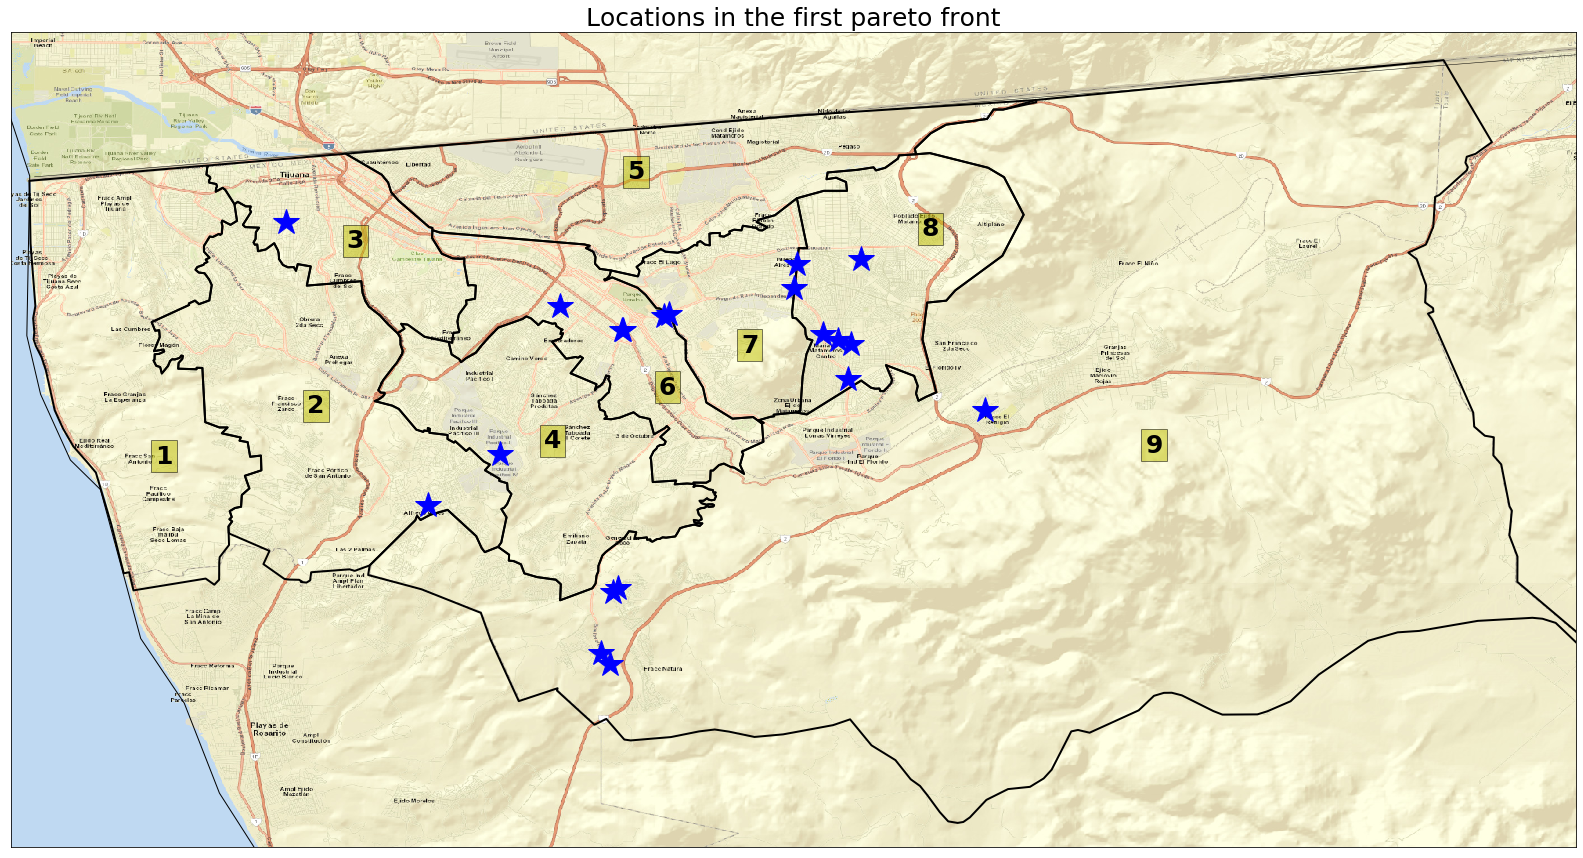

<Figure size 432x288 with 0 Axes>

In [34]:
plt.figure(figsize=(30,15))
plt.title("Locations in the first pareto front", fontsize=25)

map = Basemap(llcrnrlon=-117.13,llcrnrlat=32.33, urcrnrlon=-116.65,urcrnrlat=32.58,resolution = 'h')
map.drawcoastlines()
map.drawcountries()
map.drawstates()

# Import maps by service = 'type_of_service', example "ESRI_Imagery_World_2D", "ESRI_StreetMap_World_2D", 
# "NatGeo_World_Map", "World_Street_Map", etc... from # https://www.bdmweather.com/2018/04/python-m-arcgisimage-basemap-options/
map.arcgisimage(service='World_Street_Map', xpixels = 2000, verbose= False)

# Partition the city in districs
import_region =map.readshapefile(r"C:\Users\ahiralesc\Mysrc\notebooks\tijuana_vehicle_network_analysis\data\Delegaciones-polygon", "Delegaciones-polygon", color='k',linewidth=2)

    
#texto en mapa
for district in districts.values:
    lat, lon= district[1], district[2]
    x, y=map(lon,lat)
    plt.text(x,y,str(int(district[0])),fontsize=25,fontweight='bold',ha='left',va='center',color='k', bbox=dict(facecolor='y', alpha=0.5)) 

# Plot the locations of the most important nodes
for location in front_1_points.values:
    lat = float(location[2])
    lon = float(location[1])
    x, y = map(lon, lat)
    map.plot(x, y, marker='*', markersize=27,color='b')

plt.show()
#plt.savefig('data/pareto_1_locations.png') # World_Street_Map', bbox_inches = "tight", dpi = 500


In [5]:
from ast import literal_eval
edges['Arista'] = [literal_eval(x) for x in edges['Arista']]

In [49]:
#from tqdm import tqdm_notebook
from tqdm import tqdm # for command line
import sys
from time import sleep
#from tqdm import tqdm

# Given a lenght of a path and all existing paths (in number of edges) returns the paths whose lenght is equal.
def get_path_with_lenght(lenght, nodes, all_paths):
    _source, _target = None, None
    paths = dict()
    for source in nodes.index:
        for target in nodes.index:
            if lenght == len(all_paths[source][target]):
                paths[source] = target
    return paths


# Given a path and the set of edges count number of routes that traver each each in the path
def get_path_routes(path, edges):
    segments = [(path[i],path[i+1]) for i in range(0, len(path)-1, 1)]
    segFreq = Counter()
    for segment in segments:
        segFreq = segFreq + Counter(edges[edges['Arista'] == segment]['Etiqueta'])
    return segFreq


def plot_path_lenght_frequency(path_frequency):
    sorted_path_frequency = list(path_frequency.values())
    sorted_path_frequency.sort()
    route_lenghts = Counter(sorted_path_frequency)
    plt.bar(route_lenghts.keys(),route_lenghts.values())
    plt.xlabel('Route leghts',  horizontalalignment='center')
    plt.ylabel('Frequeny', verticalalignment='center')
    plt.show()
    

def get_path_segment_table(path, edges):
    path_routes = dict()
    segments = [(path[i],path[i+1]) for i in range(0, len(path)-1, 1)]
    for segment in segments:
        for index, row in edges[edges['Arista'] == segment].iterrows():
            route = row['Etiqueta']
            segment = row['Arista']
            if route not in path_routes.keys():
                path_routes[route] = list()
            path_routes[route].append(segment)
    return path_routes


def get_min_max_transfers(path_frequency, path_routes, path):
    # Build the priority queue. Turn max values into min
    ds = UnionFind()
    transfers = set()
    TG = nx.DiGraph()
    
    for node in path:
        TG.add_node(node)

    maxqueue = []
    for tup in path_frequency.most_common():
        tup = (-tup[1], tup[0])
        heapq.heappush(maxqueue,tup)
    
    # Base case 
    if (-1 * heapq.nsmallest(1, maxqueue)[0][0]) == len(path):
        transfers.add(heapq.nsmallest(1, maxqueue)[0][1])
    else:
        while(len(maxqueue) != 0):
            mcr = heapq.heappop(maxqueue)
            for u, v in path_routes[mcr[1]]:
                if ds[u] != ds[v]:
                    ds.union(u,v)
                    transfers.add(mcr[1])
                    TG.add_edge(u,v, label=mcr[1])
    
    
    # Estimate the minumum number of transfers
    if len(transfers) == 1:
        min_transfers = 1
    else:
        min_transfers = len(transfers)-1
    
    # Estimate the max number of transfers
    max_transfers = 0
    prev = None
    for p in TG.nodes:
        for s in TG.successors(p):
            if prev == None:
                prev = TG.get_edge_data(p,s)['label']
            elif prev != TG.get_edge_data(p,s)['label']:
                    prev = TG.get_edge_data(p,s)['label']
                    max_transfers = max_transfers + 1
    
    
    return max_transfers, min_transfers, transfers, TG  



def get_mean_num_transfers(path_lenght, edges, all_paths):
    tqdm._instances.clear()
    paths = get_path_with_lenght(path_lenght, nodes, all_paths)
    num_paths = len(paths)
    mean_max_transfers, mean_min_transfers = 0, 0
    pbar = tqdm(total=num_paths, file=sys.stdout)
    i = 0
    for source, target in paths.items():
        path = all_paths[source][target]
        path_frequency = get_path_routes(path, edges)
        path_routes = get_path_segment_table(path, edges)
        max_transfers, min_transfers, transfers, TG = get_min_max_transfers(path_frequency,path_routes,path)
        mean_max_transfers = mean_max_transfers + max_transfers
        mean_min_transfers = mean_min_transfers + min_transfers
        pbar.set_description('processed: %d' % (1 + i))
        pbar.update(10)
        sleep(1)
        i = i + 1
    return (mean_max_transfers/num_paths), (mean_min_transfers/num_paths)


In [12]:
# It takes a long time to compute this!
all_paths = nx.shortest_path(G)

In [50]:
# Evaluate the average number of transitions of longest paths
mean, mean_min = get_mean_num_transfers(190, edges, all_paths)
print("\nAnalysis of the number of transfers needed for longests paths")
print('Mean transfers : ', mean)
print('Minimum mean transfers : ', mean_min)

processed: 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [04:11<00:00, 125.87s/it]
processed: 2: : 20it [00:03,  5.74it/s]                                                                                                                                                                                                     

Analysis of the number of transfers needed for longests paths
Mean transfers :  16.0
Minimum mean transfers :  10.0


In [51]:
mean, mean_min = get_mean_num_transfers(99, edges, all_paths)
print("Analysis of the number of transfers needed for longests paths")
print('Mean transfers : ', mean)
print('Minimum mean transfers : ', mean_min)

processed: 4461: : 44610it [2:59:08,  6.95it/s]                                                                                                                                                                                             Analysis of the number of transfers needed for longests paths
Mean transfers :  10.39296121945752
Minimum mean transfers :  6.942837928715535


El numero promedio de transbordos para el diametro es de 16. El diametro de la red de Tijuana esta a cuatro orden de marnitud en comparación con el diametro de la red de transporte en Brazil []. Es posible reducir el número de transbordos a 10 a cambio de encrementar el tamaño de la ruta. Para el caso del radio, el número promedio de transbordos es de 10 y su mínimo es de 6. Note, suponemos los transbordos ocurren en puntos donde se intersectan las rutas. La anterior suposición dado que es común, por falta de regulación, paradas ocurran en ubicaciones de paraje no autorizadas. Fueron 4461 pares de ubicaciones con igual radio (99 arístas).

In [68]:
# Generate one path for a pair of nodes with distance equaling 190 edges
paths = get_path_with_lenght(190, nodes, all_paths)
path = all_paths['v2497']['v1431']
print('Path with diameter : ', path)
# Generate one path for a pair of nodes with radios equaling 99 edges
paths = get_path_with_lenght(99, nodes, all_paths)
path = all_paths['v2']['v2508']
print('Path with radious : ', path)

Path with diameter :  ['v2497', 'v2498', 'v2499', 'v2500', 'v2501', 'v2502', 'v2503', 'v2504', 'v2505', 'v2506', 'v2507', 'v2508', 'v2509', 'v2510', 'v2511', 'v2512', 'v2513', 'v2514', 'v2496', 'v2495', 'v2515', 'v2516', 'v2517', 'v2518', 'v2519', 'v2520', 'v2521', 'v2522', 'v2523', 'v2524', 'v2525', 'v2526', 'v2527', 'v2528', 'v2529', 'v2530', 'v2531', 'v2532', 'v2533', 'v2534', 'v2535', 'v2536', 'v2537', 'v2538', 'v2201', 'v2539', 'v2540', 'v289', 'v298', 'v299', 'v2541', 'v2542', 'v2543', 'v2544', 'v2545', 'v2546', 'v2547', 'v2548', 'v2549', 'v2550', 'v2551', 'v2552', 'v2553', 'v2554', 'v2555', 'v2417', 'v2418', 'v2419', 'v3229', 'v3230', 'v3231', 'v3232', 'v3233', 'v3234', 'v3235', 'v3236', 'v3237', 'v3238', 'v2429', 'v2430', 'v3451', 'v3452', 'v3453', 'v3454', 'v3455', 'v3456', 'v2557', 'v1182', 'v1183', 'v1098', 'v1533', 'v1534', 'v1535', 'v1536', 'v1353', 'v1354', 'v150', 'v152', 'v153', 'v154', 'v6', 'v7', 'v8', 'v9', 'v155', 'v156', 'v157', 'v158', 'v159', 'v160', 'v161', 'v16

In [4]:
# Network average path lenght
pareto = pd.read_csv(r'data\pareto_fronts.csv',  keep_default_na=False, sep=",", encoding ="ISO-8859-1", engine='python')

In [7]:
df = pd.DataFrame(columns = ['ND','NiDC','NoDC','NBC','NCC','KNN','NCPR','NDC'])
val_set = pareto.frontera.unique()[pareto.frontera.unique() <= 10]
for i in val_set:
    p = pareto[pareto.frontera == i]['vertice']
    stats = nodes[nodes.index.isin(list(p.values))].describe()
    vals = stats[stats.index == 'mean'][['ND','NiDC','NoDC','NBC','NCC','KNN','NCPR','NDC']].values
    key = str(int(i))
    df.loc[key] = vals[0]
df = df.reset_index()
df.rename(columns = {'index':'Front'}, inplace = True) 
df = df.astype({"Front": int})
df = df.sort_values(by=['Front'],ascending=True)
df[['ND','NiDC','NoDC','NBC','NCC','KNN','NCPR','NDC']] = df[['ND','NiDC','NoDC','NBC','NCC','KNN','NCPR','NDC']].round(decimals=3)
#df['NDC'] = df[]

In [8]:
df

,Front,ND,NiDC,NoDC,NBC,NCC,KNN,NCPR,NDC
9,1,5.350,0.001,0.001,0.065,0.017,2.950,0.001,0.001
8,2,4.974,0.001,0.001,0.060,0.017,2.893,0.000,0.001
7,3,4.905,0.001,0.001,0.053,0.017,2.734,0.000,0.001
6,4,4.943,0.001,0.001,0.047,0.017,2.421,0.000,0.001
5,5,4.721,0.001,0.001,0.040,0.016,2.197,0.000,0.001
4,6,4.375,0.001,0.000,0.036,0.016,2.270,0.000,0.001
3,7,4.264,0.000,0.000,0.032,0.016,2.267,0.000,0.001
2,8,4.151,0.000,0.000,0.030,0.016,2.181,0.000,0.001
1,9,4.020,0.000,0.000,0.026,0.016,2.104,0.000,0.001
0,10,4.010,0.000,0.000,0.023,0.016,2.021,0.000,0.001


In [47]:
p = pareto[pareto.frontera == 4]['vertice']

In [40]:
sum_paths = 0;
n = 0;
for k1 in p:
    for k2 in all_paths[k1].items():
        #print(k1,k2[1][-1])
        sum_paths = sum_paths + len(all_paths[k1][k2[1][-1]])
        n = n + 1
print(sum_paths/n)

53.966319210939254


In [48]:
len(p)

53

### <a name="TVM_LIB">7. <span style="color:blue">Experimental environment setup</span></a>

To facilitate reproducibility we have exported our development environment.  "TBD"

### <a name="TVM_LIB">8. <span style="color:blue">References</span></a>

1. Gil, J. Y. & Kimmel, R.Efficient dilation, erosion, opening, and closing algorithms IEEE Transactions on Pattern Analysis and Machine Intelligence, 2002 , 24 , 1606-1617
2. Jackway, P. T. & Deriche, M. Scale-space properties of the multiscale morphological dilation-erosion IEEE Transactions on Pattern Analysis and Machine Intelligence, 1996, 18, 38-51 
3. Lin, J. & Ban, Y. Comparative Analysis on Topological Structures of Urban Street Networks. ISPRS Int. J. Geo-Information, 2017 , 6 , 295
4. Lin, J. Spatial analysis and modeling of urban transportation networks KTH, Geoinformatics, KTH, Geoinformatics, 2017 , 77.
5. Barthélemy, M. Spatial networks. Physics Reports, Elsevier BV, 2011 , 499 , 1-101 
6. Newman, M. E. J. Networks: An Introduction. Oxford University Press, 2010
7. Rodrigue, J.-P. The Geography of Transport Systems. Routledge, 2013    
8. Cardozo, O. D.; Erica Leonor, G. & Miguel Alejandro, P. Teoría de grafos y sistemas de información geográfica aplicados al transporte público de pasajeros en resistencia (Argentina). Revista Transporte y Territorio, 2009 , 89-111 
9. Jiang, B. & Claramunt, C. Topological Analysis of Urban Street Networks. Environment and Planning B: Planning and Design, SAGE Publications, 2004 , 31 , 151-162
10. Scheurer, J.; Curtis, C. & Porta, S. Spatial network analysis of public transport systems : developing a strategic planning tool to assess the congruence of movement and urban structure in Australian cities Australasian Transport Research Forum, Australasian Transport Research Forum, 2007 
11. Sevtsuk, A. & Mekonnen, M. Urban network analysis. A new toolbox for ArcGIS. Revue internationale de géomatique, Lavoisier, 2012 , 22 , 287-305
12. Viana, M. P.; Strano, E.; Bordin, P. & Barthelemy, M. The simplicity of planar networks. Scientific Reports, Springer Science and Business Media LLC, 2013 , 3
13. Harris, J.; Hirst, J. L. & Mossinghoff, M. Combinatorics and Graph Theory. Springer New York, 2008
14. Kirkley, A.; Barbosa, H.; Barthelemy, M. & Ghoshal, G.From the betweenness centrality in street networks to structural invariants in random planar graphs. Nature Communications, Springer Nature, 2018 , 9
15. Kansky, K. & Danscoine, P. Measures of network structure. Flux, PERSEE Program, 1989 , 5 , 89-121
16. Porta, S.; Crucitti, P. & Latora, V. The Network Analysis of Urban Streets: A Primal Approach. Environment and Planning B: Planning and Design, SAGE Publications, 2006 , 33 , 705-725
17. Rodrigue, J.-P.; Comtois, C. & Slack, B. The geography of transport systems, 2017 
18. Barrat, A.; Barthelemy, M.; Pastor-Satorras, R. & Vespignani, A. The architecture of complex weighted networks. Proceedings of the National Academy of Sciences, Proceedings of the National Academy of Sciences, 2004 , 101 , 3747-3752
19. Lin, J. & Ban, Y. Complex Network Topology of Transportation Systems Transport Reviews, Routledge, 2013 , 33 , 658-685 
20. Mones, E.; Vicsek, L. & Vicsek, T. Boccaletti, S. (Ed.). Hierarchy Measure for Complex Networks. PLoS ONE, Public Library of Science (PLoS), 2012 , 7 , e33799
21. Saramäki, J.; Kivelä, M.; Onnela, J.-P.; Kaski, K. & Kertész, J. Generalizations of the clustering coefficient to weighted complex networks. Physical Review E, American Physical Society (APS), 2007 , 75
22. Fagiolo, G. Clustering in complex directed networks. Physical Review E, American Physical Society (APS), 2007 , 76
23. Schank, T. & Wagner, D. Approximating Clustering Coefficient and Transitivity. Journal of Graph Algorithms and Applications, 2005 , 9 , 265-275
24. Opsahl, T. & Panzarasa, P. Clustering in weighted networks. Social Networks, Elsevier BV, 2009 , 31 , 155-163
25. S. Boccaletti, V. Latora, Y. Moreno, M. Chavez, and D Hwang. Complex networks:
Structure and dynamics. Physics Reports, 424(4-5):175–308, February 2006.
26. Nitin R. Chopde and Mangesh K. Nichat. Landmark based shortest path detection
by using A* and haversine formula. International Journal of Innovative Research
in Computer and Communication Engineering, 1(2):298–302, April 2013.
27. Carlos A. Coello Coello, Gary B. Lamont, and David A. Van Veldhuizen. Evolutionary algorithms for solving multi-objective problems (Genetic and Evolutionary
Computation). Springer-Verlag New York, Inc., Secaucus, NJ, USA, 2006. Evolutionary.
28. J. G. Foster, D. V. Foster, P. Grassberger, and M. Paczuski. Edge direction
and the structure of networks. Proceedings of the National Academy of Sciences,
107(24):10815–10820, May 2010.
29. Amy N. Langville and Carl D. Meyer. A survey of eigenvector methods for web
information retrieval. SIAM Review, 47(1):135–161, January 2005.
30. M. E. J. Newman. Mixing patterns in networks. Physical Review E, 67(2), February
2003.
31. Lawrence Page, Sergey Brin, Rajeev Motwani, and Terry Winograd. The PageRank
citation ranking: Bringing order to the web. Technical Report 1999-66, Stanford
InfoLab, November 1999.
32. Thomas Schank and Dorothea Wagner. Approximating clustering coefficient and
transitivity. J. Graph Algorithms Appl., 9(2):265–275, 2005.
